<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/w207_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing the libraries***

In [80]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import cv2 as cv
import skimage.io as skio

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ***Downloading titanic data set from Kaggle, it will download a zip file from Kaggle platform to Google Colab***

In [51]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.28G/6.31G [01:01<00:00, 205MB/s]
100% 6.31G/6.31G [01:01<00:00, 110MB/s]


# ***Unzipping the downaloaded zip files and then remove the actual zip file***

In [52]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

# ***Train Files Count***

In [53]:
!ls -ltr /content/train/ |wc -l

220026


# ***Validate train_labels.csv file count, it should match with train file count***

In [54]:
!wc -l train_labels.csv

220026 train_labels.csv


# ***Test Files Count***

In [55]:
!ls -ltr /content/test/ |wc -l

57459


# ***Validate submission file count, it should match with test file count***

In [56]:
!wc -l sample_submission.csv

57459 sample_submission.csv


In [57]:
tf.__version__

'2.8.2'

In [58]:
# declare constants for reproduciblity
RANDOM_STATE = 20220922

# ***Explore file structure of train_labels.csv***

In [59]:
!head train_labels.csv

id,label
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0
acfe80838488fae3c89bd21ade75be5c34e66be7,0
a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
559e55a64c9ba828f700e948f6886f4cea919261,0


# ***Explore file structure of sample_submission.csv***

In [60]:
!head sample_submission.csv

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
aa0307865281d4484ddf8c637c348292968b93a7,0
f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0


# ***Read files***

In [61]:
#get files
current_working_dir = os.getcwd()
train_path = 'train/'
test_path = 'test/'

train_file_list = []
for train_file_name in glob.glob(os.path.join(current_working_dir, train_path)+'*.tif'):
    train_file_list.append(train_file_name)
train_label = pd.read_csv('train_labels.csv')

test_file_list = []
for test_file_name in glob.glob(os.path.join(current_working_dir, test_path)+'*.tif'):
    test_file_list.append(test_file_name)

test_label = pd.read_csv('sample_submission.csv')

In [62]:
print(f"Number of train files : {len(train_file_list)}")
print(f"Number of train files : {len(test_file_list)}")

Number of train files : 220025
Number of train files : 57458


Text(0.5, 1.0, 'Train Data label Count')

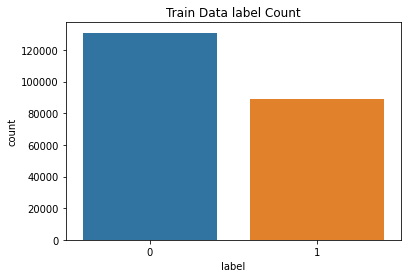

In [63]:
sns.countplot(data = train_label, x = 'label')
plt.title("Train Data label Count")

In [64]:
fig = px.pie(train_label, 
             values = train_label['label'].value_counts().values, 
             names = train_label['label'].unique())
fig.update_layout(
    title={
        'text': "Train Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Text(0.5, 1.0, 'Test Data label Count')

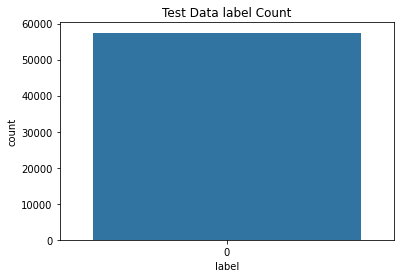

In [65]:
sns.countplot(data = test_label, x = 'label')
plt.title("Test Data label Count")

In [66]:
fig = px.pie(test_label, 
             values = test_label['label'].value_counts().values, 
             names = test_label['label'].unique())
fig.update_layout(
    title={
        'text': "Test Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# ***This data contains 220,025 train images and 57,458 test images (Tiff Files). All the images are 96 X 96 color images (with 3 channels). We are also given train_labels.csv and sample_submission.csv which contain label information for train and test images respectively.***

# ***Seperating postive and nagetive images from the training data***

In [67]:
train_positive_image_id_list = list(train_label[train_label.label==1].id)
train_negative_image_id_list = list(train_label[train_label.label==0].id)

train_positive_images_list = [os.path.join(current_working_dir, train_path) + img + '.tif' for img in train_positive_image_id_list]
train_negative_images_list = [os.path.join(current_working_dir, train_path) + img + '.tif' for img in train_negative_image_id_list]

print(f"Number of positive images in train set: {len(train_positive_images_list)}")
print(f"Number of negative images in train set: {len(train_negative_images_list)}")

Number of positive images in train set: 89117
Number of negative images in train set: 130908


# ***Printing postive images (Cancer present)***

226.55577256944446


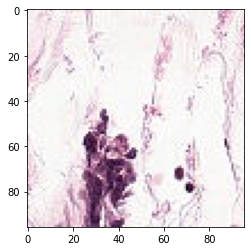

161.09284577546296


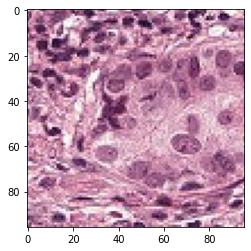

211.74638310185185


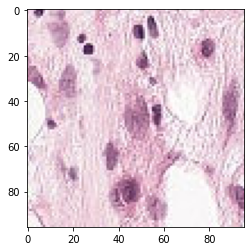

149.81477864583334


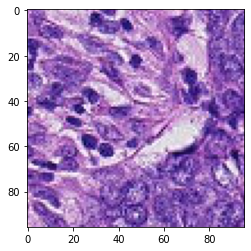

185.62257667824073


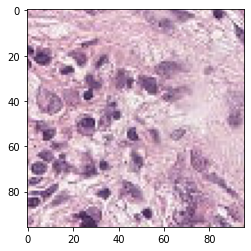

141.09942853009258


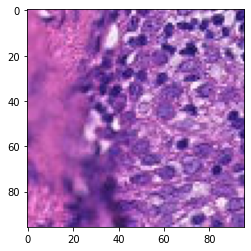

177.36899594907408


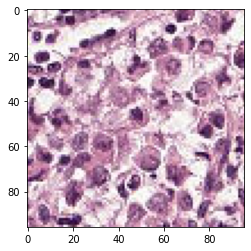

164.01052517361111


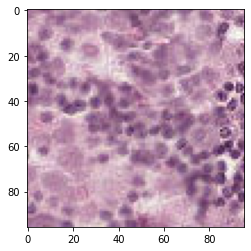

202.32429108796296


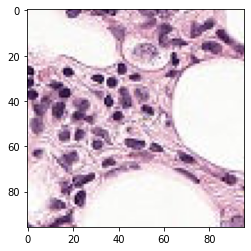

95.02379918981481


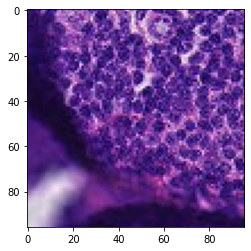

In [68]:
for train_file in train_positive_images_list[:10]:
    train_image = skio.imread(train_file, plugin = "tifffile")
    print(train_image.mean())
    plt.imshow(train_image)
    plt.show()

# ***Printing negative images (No cancer present)***

232.89011863425927


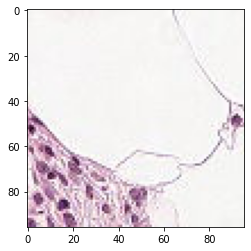

172.53743489583334


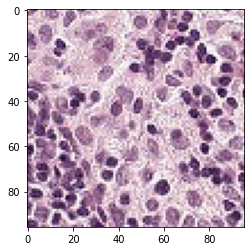

179.9046947337963


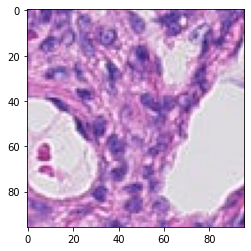

115.15281394675925


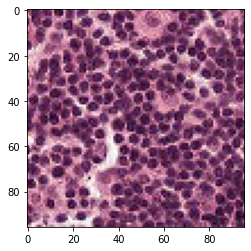

146.42039207175927


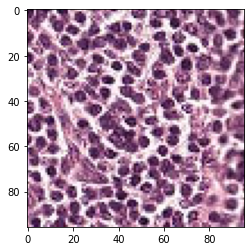

176.6630497685185


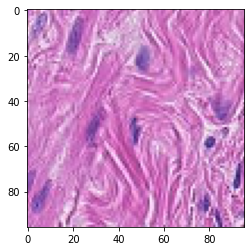

142.71260127314815


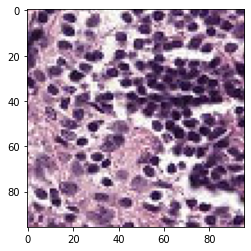

229.21115451388889


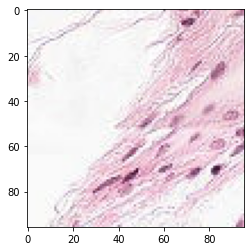

224.77756076388889


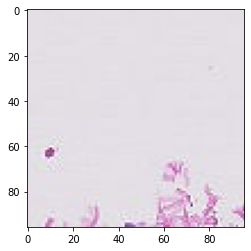

217.2851924189815


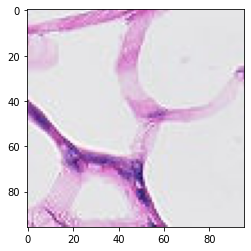

In [69]:
for train_file in train_negative_images_list[:10]:
    train_image = skio.imread(train_file, plugin = "tifffile")
    print(train_image.mean())
    plt.imshow(train_image)
    plt.show()

# ***As the test data set does not have any labels present, we decide to use the parts of the train data for validation and test purpose. So we are creating a folder named interim_pricessing to store our train, validation and test impages, sampled from original input train data set.***

In [70]:
!mkdir interim_processing

!mkdir interim_processing/interim_train 
!mkdir interim_processing/interim_validation 
!mkdir interim_processing/interim_test

!mkdir interim_processing/interim_train/positive
!mkdir interim_processing/interim_validation/positive 
!mkdir interim_processing/interim_test/positive

!mkdir interim_processing/interim_train/negative
!mkdir interim_processing/interim_validation/negative 
!mkdir interim_processing/interim_test/negative

mkdir: cannot create directory ‘interim_processing’: File exists
mkdir: cannot create directory ‘interim_processing/interim_train’: File exists
mkdir: cannot create directory ‘interim_processing/interim_validation’: File exists
mkdir: cannot create directory ‘interim_processing/interim_test’: File exists


# ***We split original input images in 70%, 20% and 10% split amongst train, validation and test set and they will be stored in the respective folders.***

In [93]:
# Shuffling data
shuffled_train_label = shuffle(train_label)
len_shuffled_train_label = len(shuffled_train_label)
#print(f"Length of shuffled_train_label : {len_shuffled_train_label}")
#print(f"Length of train data : {np.round(len_shuffled_train_label * .7).astype(int)}")
#print(f"Length of validation data : {np.round(len_shuffled_train_label * .2).astype(int)}")
#print(f"Length of test data : {len_shuffled_train_label - np.round(len_shuffled_train_label * .7).astype(int) - np.round(len_shuffled_train_label * .2).astype(int)}")

print(f"Number of positive imgaes in train set is : ", np.round(len(train_positive_images_list) * .7).astype(int))
print(f"Number of positive imgaes in validation set is : ", np.round(len(train_positive_images_list) * .2).astype(int))
print(f"Number of positive imgaes in validation set is : ", len(train_positive_images_list) - np.round(len(train_positive_images_list) * .7).astype(int) - np.round(len(train_positive_images_list) * .2).astype(int))

print(f"Number of negative imgaes in train set is : ", np.round(len(train_positive_images_list) * .7).astype(int))
print(f"Number of negative imgaes in validation set is : ", np.round(len(train_positive_images_list) * .2).astype(int))
print(f"Number of negative imgaes in validation set is : ", len(train_positive_images_list) - np.round(len(train_positive_images_list) * .7).astype(int) - np.round(len(train_positive_images_list) * .2).astype(int))

Number of positive imgaes in train set is :  62382
Number of positive imgaes in validation set is :  17823
Number of positive imgaes in validation set is :  8912
Number of negative imgaes in train set is :  62382
Number of negative imgaes in validation set is :  17823
Number of negative imgaes in validation set is :  8912


In [90]:
np.round(len(train_positive_images_list) * .7).astype(int), np.round(len(train_positive_images_list) * .2).astype(int), len(train_positive_images_list) - np.round(len(train_positive_images_list) * .7).astype(int) - np.round(len(train_positive_images_list) * .2).astype(int)

(62382, 17823, 8912)